Loading audio file...
Preserving original sample rate of 44100 Hz...
Computing MFCCs...


12656700it [00:01, 12620910.25it/s]                                                                                    

Applying diagonal smoothing...


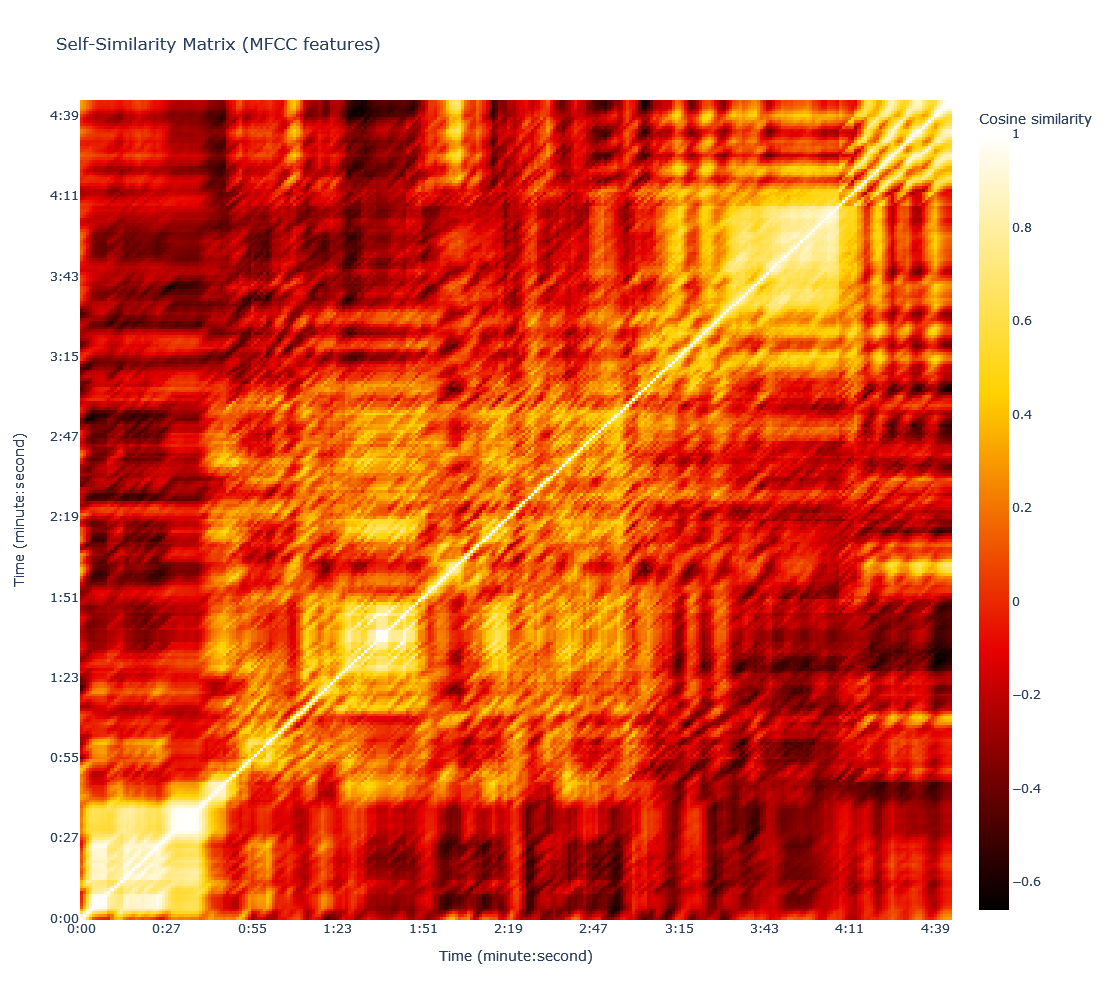

In [3]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import librosa
from scipy.signal import convolve2d
from tqdm import tqdm
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import plotly.io as pio

# Customizable variables
resample = False  # Set this to False to preserve original sr
custom_sr = 44100  # Modify this to change the custom sr
analysis_method = 'mfcc'  # Modify this to 'chroma', 'mfcc', or 'chroma+mfcc'
file_path = 'de natura sonorum - première série - accidents - harmoniques.wav'  # Modify this to change the audio file path
mfcc_start = 0  # start of interval (included)
mfcc_end = 19  # end of interval (excluded)
window = 1  # Modify this to change the window size (s)
diagonal_smooth_width = 5  # Modify this to change the diagonal smoothing width

def diagonal_smooth(mat, width):
    if width <= 1:
        return mat
    kernel = np.eye(width)
    kernel /= kernel.sum()
    smoothed = convolve2d(mat, kernel, mode='same', boundary='symm')
    return smoothed

print("Loading audio file...")
if resample:
    print(f"Downsampling to {custom_sr} Hz...")
    y, sr = librosa.load(file_path, mono=True, sr=custom_sr)
else:
    y, sr = librosa.load(file_path, mono=True, sr=None)
    print(f"Preserving original sample rate of {sr} Hz...")

# Define window and calculate hop_length after sr has been defined
hop_length = int(sr * window)  # Convert to int to ensure it's a valid value for slicing

if analysis_method in ['chroma', 'chroma+mfcc']:
    print("Computing chromagram...")
    chroma_features = []
    with tqdm(total=y.shape[0]) as pbar:
        for i in range(0, y.shape[0], hop_length):
            frame = y[i:i+hop_length]
            if analysis_method in ['chroma', 'chroma+mfcc']:
                c = librosa.feature.chroma_stft(y=frame, sr=sr)
                chroma_features.append(np.mean(c, axis=1))
            pbar.update(hop_length)
    chroma_features = np.array(chroma_features).T

if analysis_method in ['mfcc', 'chroma+mfcc']:
    print("Computing MFCCs...")
    mfcc_features = []
    with tqdm(total=y.shape[0]) as pbar:
        for i in range(0, y.shape[0], hop_length):
            frame = y[i:i+hop_length]
            if analysis_method in ['mfcc', 'chroma+mfcc']:
                m = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=mfcc_end)
                m = m[mfcc_start:mfcc_end, :]
                mfcc_features.append(np.mean(m, axis=1))
            pbar.update(hop_length)
    mfcc_features = np.array(mfcc_features).T

if analysis_method == 'chroma+mfcc':
    # Combine chroma and mfcc features
    features = np.concatenate((chroma_features, mfcc_features), axis=0)
    title = 'Self-Similarity Matrix (chroma+mfcc features)'
elif analysis_method == 'chroma':
    features = chroma_features
    title = 'Self-Similarity Matrix (chroma features)'
elif analysis_method == 'mfcc':
    features = mfcc_features
    title = 'Self-Similarity Matrix (MFCC features)'
else:
    raise ValueError(f"Invalid analysis method: {analysis_method}. Choose 'chroma', 'mfcc', or 'chroma+mfcc'.")


# Normalize the feature vectors
scaler = StandardScaler()
features_norm = scaler.fit_transform(features.T)

# Compute the SSM using cosine similarity
ssm = cosine_similarity(features_norm)

# apply diagonal smoothing
print("Applying diagonal smoothing...")
ssm = diagonal_smooth(ssm, width=5)

duration_sec = librosa.get_duration(y=y, sr=sr)
time_data_sec = [i*duration_sec/ssm.shape[0] for i in range(ssm.shape[0])]
time_data_min_sec = [f"{int(t // 60)}:{int(t % 60):02}" for t in time_data_sec]

# Set the step size to have 10 ticks per axis
step_size = len(time_data_min_sec) // 10
tickvals = [i for i in range(0, len(time_data_min_sec), step_size)]

heatmap = go.Heatmap(
    x=time_data_min_sec,
    y=time_data_min_sec,
    z=ssm,
    colorscale='Hot',
    colorbar=dict(title='Cosine similarity'),
)

layout = go.Layout(
    title=title,
    xaxis=dict(title='Time (minute:second)', tickvals=tickvals, ticktext=[time_data_min_sec[i] for i in tickvals]),
    yaxis=dict(title='Time (minute:second)', tickvals=tickvals, ticktext=[time_data_min_sec[i] for i in tickvals]),
    autosize=False,
    width=1000,
    height=1000,
)

fig = go.Figure(data=[heatmap], layout=layout)
fig.show()